In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import statsmodels.api as sm


# Catfish Sales Data

In [93]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [94]:
#read data
catfish_sales = pd.read_csv('/kaggle/input/catfish/catfish.csv', parse_dates=[0], index_col=0,  date_parser=parser)

/tmp/ipykernel_34/1422054886.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('/kaggle/input/catfish/catfish.csv', parse_dates=[0], index_col=0,  date_parser=parser)


In [95]:
catfish_sales.head(15)

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
1986-06-01,8951
1986-07-01,9668
1986-08-01,10188
1986-09-01,9896


In [96]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [97]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

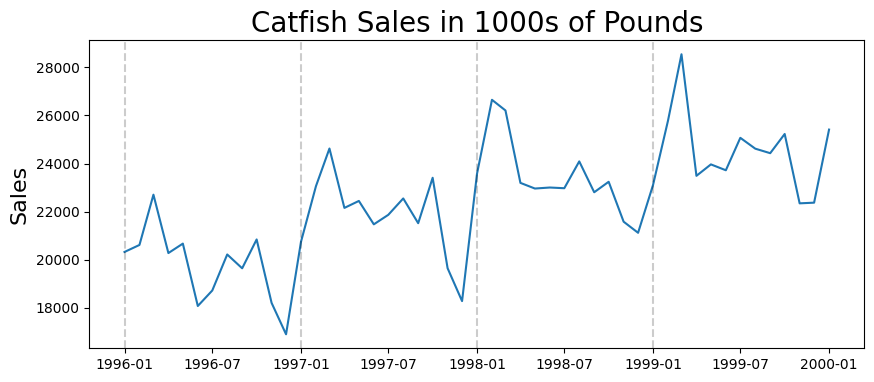

In [98]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [99]:
first_diff = lim_catfish_sales.diff()[1:]

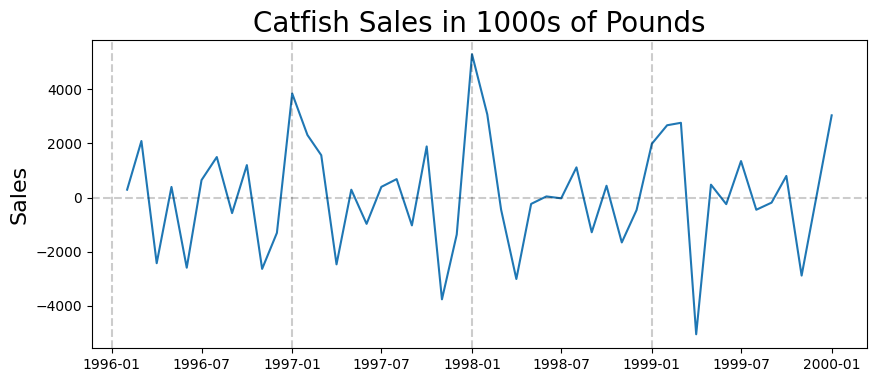

In [100]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

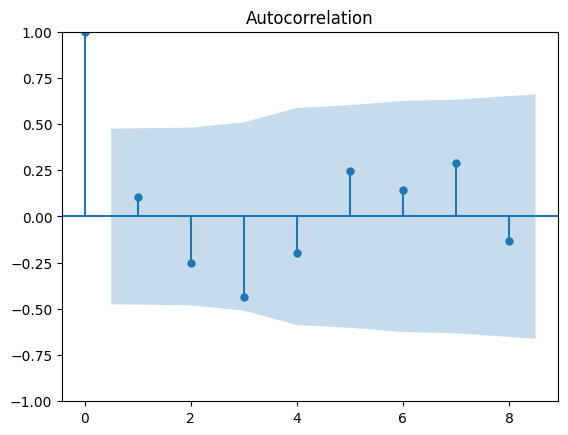

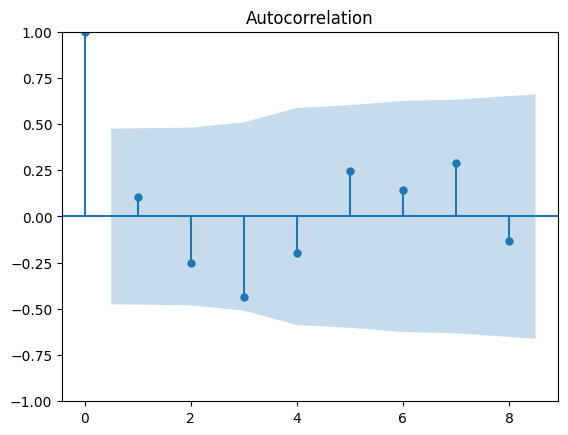

In [101]:
acf_vals = acf(first_diff)
num_lags = 20
#plt.bar(range(num_lags), acf_vals[:num_lags])
sm.graphics.tsa.plot_acf(acf_vals)

## Based on ACF, we should start with a seasonal MA process

# PACF

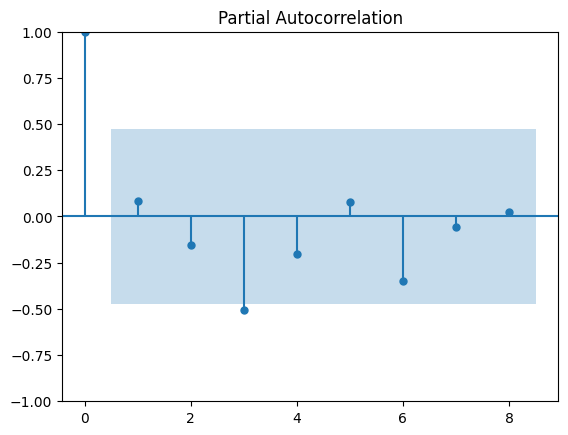

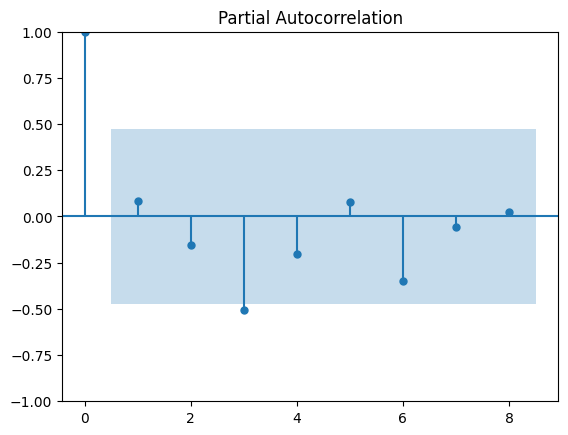

In [102]:
pacf_vals = pacf(first_diff)
num_lags = 15
#plt.bar(range(num_lags), pacf_vals[:num_lags])
sm.graphics.tsa.plot_pacf(pacf_vals)

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [103]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

In [104]:
len(test_data)

6

# Fit the SARIMA Model

In [105]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [106]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88111D+00    |proj g|=  1.26626D+00

At iterate    5    f=  8.57512D+00    |proj g|=  3.01676D-01

At iterate   10    f=  8.55001D+00    |proj g|=  1.38247D-03

At iterate   15    f=  8.55001D+00    |proj g|=  1.09204D-03

At iterate   20    f=  8.54985D+00    |proj g|=  1.51809D-02

At iterate   25    f=  8.54232D+00    |proj g|=  1.11473D-01

At iterate   30    f=  8.51785D+00    |proj g|=  1.03001D-02

At iterate   35    f=  8.51071D+00    |proj g|=  1.52217D-01

At iterate   40    f=  8.50313D+00    |proj g|=  9.28004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [107]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Tue, 11 Jun 2024   AIC                            737.269
Time:                                      08:20:29   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [132]:
#get the predictions and residuals
predictions = model_fit.forecast(6)
predictions = pd.Series(predictions, index=test_data.index)
print(predictions)


Date
1999-08-01    25695.477303
1999-09-01    25054.188123
1999-10-01    25642.858595
1999-11-01    24195.593401
1999-12-01    23677.341665
2000-01-01    26250.597178
Freq: MS, Name: predicted_mean, dtype: float64


In [133]:
predictions.index.name='Date'

In [148]:
#predictions.to_frame(name="Total")
predictions=pd.DataFrame(predictions)

In [157]:
predictions = predictions.rename(columns={'predicted_mean': 'Total'})
predictions.head()

,Total
Date,
1999-08-01,25695.477303
1999-09-01,25054.188123
1999-10-01,25642.858595
1999-11-01,24195.593401
1999-12-01,23677.341665


In [161]:
residuals = test_data["Total"] - predictions["Total"]
residuals

Date
1999-08-01   -1077.477303
1999-09-01    -624.188123
1999-10-01    -413.858595
1999-11-01   -1851.593401
1999-12-01   -1305.341665
2000-01-01    -838.597178
Freq: MS, Name: Total, dtype: float64

Text(0, 0.5, 'Error')

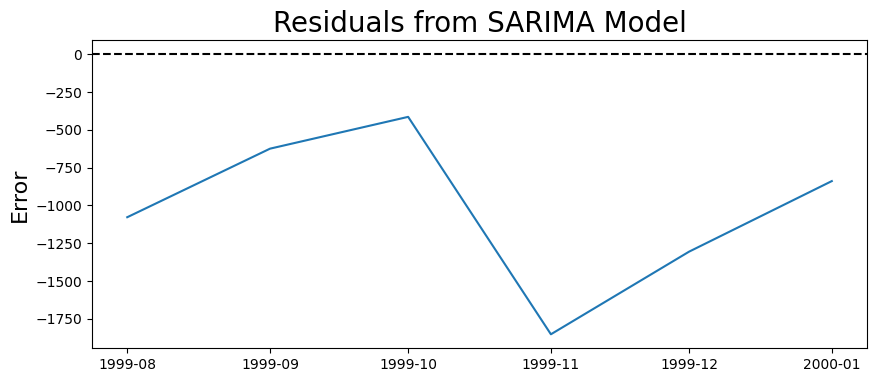

In [163]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

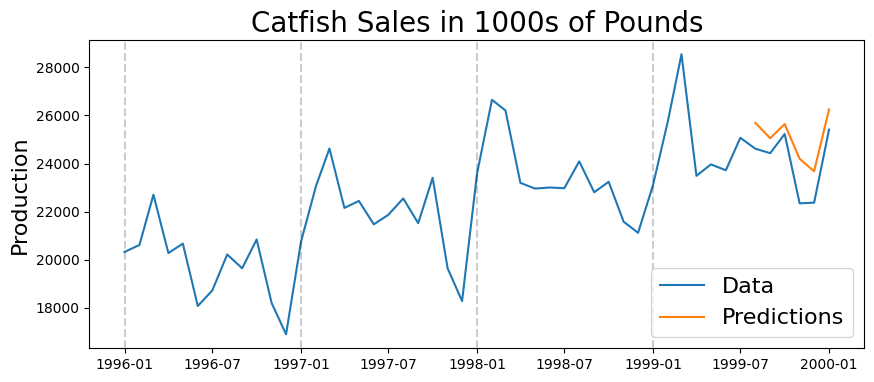

In [164]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [165]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: nan


In [166]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3047197056494
